## Import Data

ModuleNotFoundError: No module named 'google'

## Import libraries and dependencies

In [9]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from xgboost import XGBRegressor

import shap
import joblib

## Data Loading

In [10]:
# Load the CSV file
file_path = r'C:\Users\jrobe\Documents\Project 4\Project-41\Project-4\Resources\cars_us_2022.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head(15)

,Unnamed: 0,Brand,Model.Number,Price,Photo,Engine.Type,Body.Type,Fuel.Type,Gearbox.Type,Power.hp,...,CD.Player,DVD.Player,Electric.Adjustable.Seats,Keyless.Entry,Tyre.Pressure.Monitor,Smart.Access.Card.Entry,Xenon.Headlamps,Halogen.Headlamps,Removable.Convertible.Top,Cassette.Player
0,1,Honda,Accord Hybrid Sport-L 2023,31670.0,https://www.ccarprice.com/products/Honda_Accor...,2.0L Inline-4 Hybrid,Sedan,Hybrid,CVT,204.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Honda,Accord Sedan 2023,28000.0,https://www.ccarprice.com/products/Honda_Accor...,1.5L Turbo Inline-4 Gas,Sedan,Petrol,CVT,192.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Honda,ZR-V 2023,25000.0,https://www.ccarprice.com/products/Honda_ZRV_2...,2.0L Inline-4,SUV,Petrol,CVT,158.0,...,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Honda,HR-V VTi-S 2022,27800.0,https://www.ccarprice.com/products/Honda_HR-V_...,2.0L Inline-4 Gas,SUV,Petrol,CVT,119.0,...,NaN,NaN,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Honda,HR-V VTi 2022,26900.0,https://www.ccarprice.com/products/Honda_HR-V_...,2.0L Inline-4 Gas,SUV,Petrol,CVT,119.0,...,NaN,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN
5,6,Honda,Civic Sport 2023,25440.0,https://www.ccarprice.com/products/Honda_Civic...,2.0L Inline-4 Gas,Hatchback,Petrol,CVT,158.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,Honda,CR-V LX 2023,29990.0,https://www.ccarprice.com/products/Honda_CR_V_...,1.5L Turbo Inline-4 Gas,SUV,Petrol,CVT,190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,Honda,Clarity Fuel Cell 2023,65000.0,https://www.ccarprice.com/products/Honda_Clari...,Electric,Sedan,Electric,Automatic,174.0,...,NaN,NaN,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
8,9,Honda,Ridgeline Black Edition 2023,46230.0,https://www.ccarprice.com/products/Honda_Ridge...,3.5L V6 Gas,SUV,Petrol,Automatic,280.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,Honda,CR-V EX-L 2023,33760.0,https://www.ccarprice.com/products/Honda_CR-V_...,1.5-liter Turbo Inline-4 Gas,SUV,Petrol,CVT,190.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [11]:
# Display general information about the dataframe
data.info()
print()

# Display the number of missing values in each column
print(data.isnull().sum())

# Extract year from 'Model.Number' if available, else set to NaN
data['Year'] = data['Model.Number'].str.extract(r'(\d{4})')
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')

# Keep only the rows where the Year is either 2022 or 2023
data = data[data['Year'].isin([2022, 2023])].copy()

# Add 'Age' column based on the 'Year' column
current_year = 2024
data.loc[:, 'Age'] = current_year - data['Year']

# Ensure 'Mileage' column is present and fill missing values with 0
if 'Mileage' in data.columns:
    data.loc[:, 'Mileage'] = data['Mileage'].fillna(0)
else:
    data.loc[:, 'Mileage'] = 0

# Feature Engineering: Create new features based on existing data
data.loc[:, 'Power_to_Weight_Ratio'] = data['Power.hp'] / data['Displacement.l']
data.loc[:, 'Torque_to_Weight_Ratio'] = data['Torque.lbft'] / data['Displacement.l']
data.loc[:, 'Fuel_Efficiency'] = (data['MPG.City'] + data['MPG.Highway']) / 2

# Fill missing values with median for numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
data.loc[:, numeric_cols] = data[numeric_cols].apply(lambda col: col.fillna(col.median()))

# Convert categorical variables to dummy variables if they exist in the data
categorical_columns = ['Brand', 'Engine.Type', 'Body.Type', 'Fuel.Type', 'Gearbox.Type']
available_categorical_columns = [col for col in categorical_columns if col in data.columns]
data = pd.get_dummies(data, columns=available_categorical_columns, drop_first=True)

print()

# Verify cleaned data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2602 entries, 0 to 2601
Data columns (total 76 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         2602 non-null   int64  
 1   Brand                              2602 non-null   object 
 2   Model.Number                       2602 non-null   object 
 3   Price                              2602 non-null   float64
 4   Photo                              2602 non-null   object 
 5   Engine.Type                        2527 non-null   object 
 6   Body.Type                          2564 non-null   object 
 7   Fuel.Type                          2602 non-null   object 
 8   Gearbox.Type                       2602 non-null   object 
 9   Power.hp                           2256 non-null   float64
 10  Displacement.l                     2023 non-null   float64
 11  Torque.lbft                        2168 non-null   float

## Data Splitting

In [12]:
# Define features (X) and target (y)
X = data.drop(columns=['Unnamed: 0', 'Photo', 'Price', 'Model.Number', 'Year'])
y = data['Price']

# Fill missing values in numeric columns only
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].apply(lambda col: col.fillna(col.median()))

# Ensure no non-numeric columns exist in the features
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found and will be dropped: {non_numeric_cols}")
    X = X.drop(columns=non_numeric_cols)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Non-numeric columns found and will be dropped: Index(['Drivetrain', 'Air.Conditioner', 'Heater', 'AntiLock.Braking.System',
       'Central.Locking', 'Power.Steering', 'Power.Windows', 'Leather.Seats',
       'Anti.Lock.Braking', 'Brake.Assist',
       ...
       'Body.Type_Sedan', 'Body.Type_Truck', 'Body.Type_Van',
       'Body.Type_Wagon', 'Fuel.Type_Electric', 'Fuel.Type_Hybrid',
       'Fuel.Type_Petrol', 'Fuel.Type_Unknown', 'Gearbox.Type_CVT',
       'Gearbox.Type_Manual'],
      dtype='object', length=465)


## Model Training and Evaluation

In [13]:
# Initialize the scaler
scaler = StandardScaler()

# Scale the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
joblib.dump(scaler, 'scaler.pkl')

# Train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test_scaled)

# Evaluate the Linear Regression model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mse_linear)
r2_linear = r2_score(y_test, y_pred_linear)
accuracy_linear = (1 - (mae_linear / y_test.mean())) * 100

print(f"Linear Regression - MAE: {mae_linear}")
print(f"Linear Regression - MSE: {mse_linear}")
print(f"Linear Regression - RMSE: {rmse_linear}")
print(f"Linear Regression - R2: {r2_linear}")
print(f"Linear Regression - Accuracy: {accuracy_linear:.2f}%")

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=30, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the Random Forest model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
accuracy_rf = (1 - (mae_rf / y_test.mean())) * 100

print(f"Random Forest - MAE: {mae_rf}")
print(f"Random Forest - MSE: {mse_rf}")
print(f"Random Forest - RMSE: {rmse_rf}")
print(f"Random Forest - R2: {r2_rf}")
print(f"Random Forest - Accuracy: {accuracy_rf:.2f}%")

# Save the models and columns
joblib.dump((rf_model, X.columns), 'best_rf_model_with_columns.pkl')
joblib.dump((linear_model, X.columns), 'best_linear_model_with_columns.pkl')

Linear Regression - MAE: 157025.24740899418
Linear Regression - MSE: 78034885044.34586
Linear Regression - RMSE: 279347.24814170954
Linear Regression - R2: 0.3336418920931299
Linear Regression - Accuracy: -35.75%
Random Forest - MAE: 44461.75948677504
Random Forest - MSE: 29099038538.918224
Random Forest - RMSE: 170584.40297670307
Random Forest - R2: 0.751516514034929
Random Forest - Accuracy: 61.56%


['best_linear_model_with_columns.pkl']

## Advanced Model Training with Random Forest

In [14]:
# Clean and scale the data
def clean_and_scale_data(X, y, scaler=None):
    X_cleaned = X.copy()
    y_cleaned = y.copy()

    # Remove outliers (e.g., prices > $100,000 or <= 0)
    y_cleaned = y_cleaned[(y_cleaned > 0) & (y_cleaned < 100000)]
    X_cleaned = X_cleaned.loc[y_cleaned.index]

    # Scale the features
    if scaler is None:
        scaler = StandardScaler()
        X_cleaned_scaled = scaler.fit_transform(X_cleaned)
    else:
        X_cleaned_scaled = scaler.transform(X_cleaned)

    return X_cleaned_scaled, y_cleaned, scaler

# Clean and scale the training and test data
X_train_cleaned_scaled, y_train_cleaned, scaler = clean_and_scale_data(X_train, y_train)
X_test_cleaned_scaled, y_test_cleaned, _ = clean_and_scale_data(X_test, y_test, scaler)

# Create a pipeline for scaling and model training
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Use StandardScaler here
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train_cleaned_scaled, y_train_cleaned)

# Make predictions on the test set
y_pred = pipeline.predict(X_test_cleaned_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test_cleaned, y_pred)
mse = mean_squared_error(y_test_cleaned, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_cleaned, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

# Accuracy calculation
accuracy = (1 - (mae / y_test_cleaned.mean())) * 100
print(f"Model Accuracy: {accuracy:.2f}%")

# Save the model pipeline
joblib.dump((pipeline, X.columns), 'best_rf_model_with_columns.pkl')

# Define parameter grid
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_features': ['sqrt', 'log2'],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_cleaned_scaled, y_train_cleaned)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Update the pipeline with the best parameters
pipeline.set_params(model__n_estimators=best_params['model__n_estimators'],
                    model__max_features=best_params['model__max_features'],
                    model__max_depth=best_params['model__max_depth'],
                    model__min_samples_split=best_params['model__min_samples_split'],
                    model__min_samples_leaf=best_params['model__min_samples_leaf'])

# Fit the pipeline with the best parameters
pipeline.fit(X_train_cleaned_scaled, y_train_cleaned)

# Make predictions on the test set
y_pred = pipeline.predict(X_test_cleaned_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test_cleaned, y_pred)
mse = mean_squared_error(y_test_cleaned, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_cleaned, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

# Accuracy calculation
accuracy = (1 - (mae / y_test_cleaned.mean())) * 100
print(f"Model Accuracy: {accuracy:.2f}%")

MAE: 4820.248245404958
MSE: 51913699.830206685
RMSE: 7205.116226002651
R2: 0.8857108096814714
Model Accuracy: 88.97%
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
MAE: 4755.416568671193
MSE: 49063493.40055682
RMSE: 7004.533774674573
R2: 0.8919856039294399
Model Accuracy: 89.12%


## Optimizing Model

### Step 1: Review Feature Importances

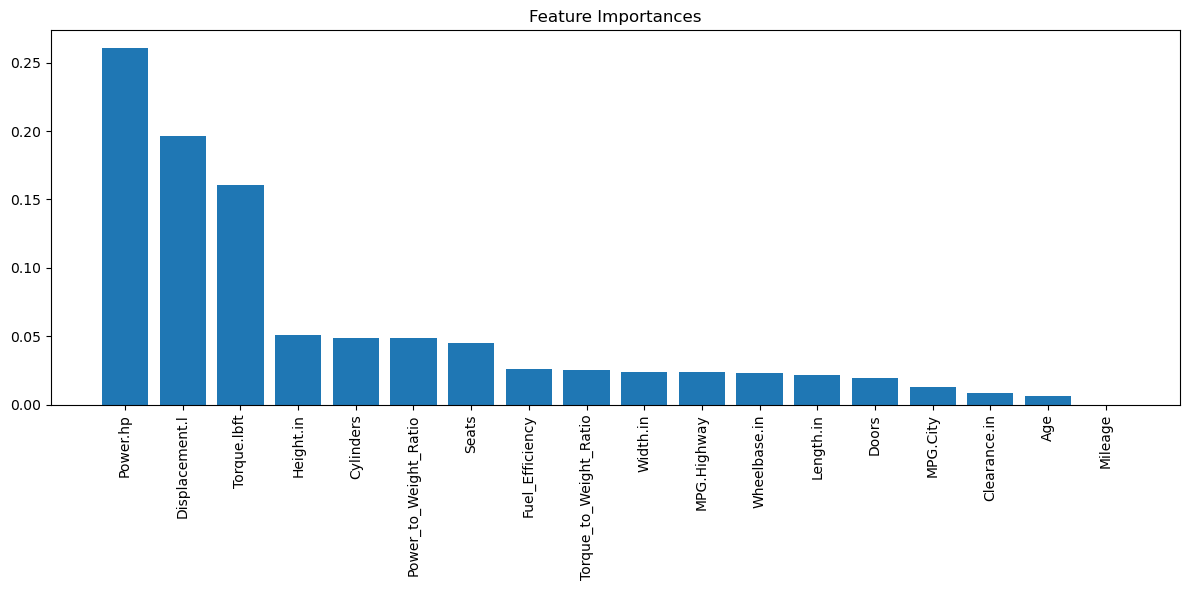

In [15]:
# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Ensure the lengths match
if len(importances) == len(features):
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices], align="center")
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("Mismatch in the number of features and importances.")
    print(f"Number of features: {len(features)}")
    print(f"Number of importances: {len(importances)}")

### Step 2: Hyperparameter Tuning

In [16]:
# Define parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto' and used valid options
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and retrain the model
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

rf_model_tuned = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Train the tuned model
rf_model_tuned.fit(X_train, y_train)

# Evaluate the tuned model
y_pred_tuned = rf_model_tuned.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"MAE: {mae_tuned}")
print(f"MSE: {mse_tuned}")
print(f"RMSE: {rmse_tuned}")
print(f"R2: {r2_tuned}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
MAE: 44938.18850437158
MSE: 29401084132.607704
RMSE: 171467.4433605625
R2: 0.7489372761697339


### Step 3: Data Normalization

In [17]:
# Define the scaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the Random Forest model on scaled data
rf_model_scaled = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model_scaled.fit(X_train_scaled, y_train)

# Evaluate the scaled model
y_pred_scaled = rf_model_scaled.predict(X_test_scaled)
mae_scaled = mean_absolute_error(y_test, y_pred_scaled)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
rmse_scaled = np.sqrt(mse_scaled)
r2_scaled = r2_score(y_test, y_pred_scaled)

print(f"MAE: {mae_scaled}")
print(f"MSE: {mse_scaled}")
print(f"RMSE: {rmse_scaled}")
print(f"R2: {r2_scaled}")

MAE: 49120.294393306795
MSE: 43742662223.46643
RMSE: 209147.46525709183
R2: 0.6264711914745058


## Price Prediction Example

In [18]:
# Load the trained Random Forest model
pipeline_rf_with_columns = joblib.load('best_rf_model_with_columns.pkl')
loaded_rf_model, loaded_rf_columns = pipeline_rf_with_columns

# Load the trained Linear Regression model
pipeline_lr_with_columns = joblib.load('best_linear_model_with_columns.pkl')
loaded_lr_model, loaded_lr_columns = pipeline_lr_with_columns

# Ensure loaded_columns is 1-dimensional
loaded_rf_columns = loaded_rf_columns.tolist()
loaded_lr_columns = loaded_lr_columns.tolist()

# Example car features for the prediction
car_example = {
    'Power.hp': 204.0, 'Displacement.l': 2.0, 'Torque.lbft': 247.0, 'Cylinders': 4.0,
    'MPG.City': 44.0, 'MPG.Highway': 41.0, 'Seats': 5.0, 'Doors': 4.0,
    'Height.in': 57.1, 'Length.in': 196.1, 'Width.in': 73.3, 'Wheelbase.in': 111.4,
    'Clearance.in': 5.8, 'Age': 1.0, 'Mileage': 0
}

# Convert the example to a DataFrame
car_example_df = pd.DataFrame([car_example]).reindex(columns=loaded_rf_columns, fill_value=0)

# Function to predict future prices and calculate accuracy
def predict_future_prices_and_accuracy(car_features, model, scaler, columns, actual_prices, years=3, depreciation_rate=0.1):
    predictions = []
    original_age = car_features['Age']
    original_mileage = car_features['Mileage']

    for i in range(1, years + 1):
        # Increment the 'Age' of the car by 1 year
        car_features['Age'] = original_age + i
        # Assume an additional 10,000 miles driven each year (adjust as needed)
        car_features['Mileage'] = original_mileage + (10000 * i)

        # Ensure the features used during training are consistent
        car_features_df = pd.DataFrame([car_features]).reindex(columns=columns, fill_value=0)

        # Scale the features
        car_features_scaled = scaler.transform(car_features_df)
        predicted_price = model.predict(car_features_scaled)[0]

        # Apply depreciation rate
        predicted_price *= (1 - depreciation_rate) ** i

        predictions.append(predicted_price)

    # Convert actual_prices to a NumPy array
    actual_prices_np = np.array(actual_prices)

    # Calculate accuracy
    mae = mean_absolute_error(actual_prices_np[:years], predictions)
    accuracy = (1 - (mae / actual_prices_np.mean())) * 100

    return predictions, accuracy

# Load the scaler used for training the models
scaler = joblib.load('scaler.pkl')

# Scale the example features
car_example_scaled = scaler.transform(car_example_df)

# Predict the current price using the models
current_price_rf = loaded_rf_model.predict(car_example_scaled)[0]
current_price_lr = loaded_lr_model.predict(car_example_scaled)[0]

# Define the actual prices for the next 3 years for evaluation purposes (this should come from your data)
# Example values (these should be replaced with actual values if available)
actual_prices = [30000, 27000, 24000]  # Replace with actual future prices

# Predict future prices for 2023, 2024, and 2025
future_prices_rf, accuracy_rf = predict_future_prices_and_accuracy(car_example, loaded_rf_model, scaler, loaded_rf_columns, actual_prices, years=3, depreciation_rate=0.15)
future_prices_lr, accuracy_lr = predict_future_prices_and_accuracy(car_example, loaded_lr_model, scaler, loaded_lr_columns, actual_prices, years=3, depreciation_rate=0.15)

# Display the results for Random Forest
print(f"Current price (RF): {round(current_price_rf)}")
print(f"Predicted prices for the next 3 years (RF): {[round(price) for price in future_prices_rf]}")
print(f"Accuracy of RF predictions: {accuracy_rf:.2f}%")

print()

# Display the results for Linear Regression
print(f"Current price (LR): {round(current_price_lr)}")
print(f"Predicted prices for the next 3 years (LR): {[round(price) for price in future_prices_lr]}")
print(f"Accuracy of LR predictions: {accuracy_lr:.2f}%")

Current price (RF): 36036
Predicted prices for the next 3 years (RF): [31171, 26495, 22521]
Accuracy of RF predictions: 96.11%

Current price (LR): -94198
Predicted prices for the next 3 years (LR): [-32808, -17844, -6631]
Accuracy of LR predictions: -70.72%


## Test Prediction with 3 cars over 5 years

In [19]:
# Load the trained Random Forest model
pipeline_rf_with_columns = joblib.load('best_rf_model_with_columns.pkl')
loaded_rf_model, loaded_rf_columns = pipeline_rf_with_columns

# Load the scaler used for training the models
scaler = joblib.load('scaler.pkl')

# Function to predict prices for the next 5 years
def predict_prices(car_features, model, scaler, columns, start_year, years=5, depreciation_rate=0.15):
    predictions = {}
    original_age = car_features['Age']
    original_mileage = car_features['Mileage']

    for i in range(1, years + 1):
        car_features['Age'] = original_age + i
        car_features['Mileage'] = original_mileage + (10000 * i)

        car_features_df = pd.DataFrame([car_features]).reindex(columns=columns, fill_value=0)
        car_features_scaled = scaler.transform(car_features_df)
        predicted_price = model.predict(car_features_scaled)[0]

        # Apply depreciation rate to the predicted price
        predicted_price *= (1 - depreciation_rate) ** i
        predictions[start_year + i] = round(predicted_price)

    return predictions

# Function to calculate prediction accuracy
def calculate_accuracy(predictions, actual_prices):
    actual_prices_np = np.array(actual_prices)
    predicted_prices_np = np.array(list(predictions.values())[:len(actual_prices)])
    mae = mean_absolute_error(actual_prices_np, predicted_prices_np)
    accuracy = (1 - (mae / actual_prices_np.mean())) * 100
    return accuracy

# Define the depreciation rate
depreciation_rate = 0.15

# Select 3 random cars from the dataset
sample_cars = data.sample(3)

# Display the predictions for the selected cars
for index, car in sample_cars.iterrows():
    model = car['Model.Number']
    year = int(car['Model.Number'].split()[-1])
    initial_price = car['Price']

    car_features = car.drop(['Unnamed: 0', 'Photo', 'Price', 'Model.Number', 'Year']).to_dict()

    predictions = predict_prices(car_features, loaded_rf_model, scaler, loaded_rf_columns, year, depreciation_rate=depreciation_rate)

    # Define the actual prices for the next 5 years for evaluation purposes
    actual_prices = [initial_price * (1 - depreciation_rate) ** i for i in range(1, 6)]

    accuracy = calculate_accuracy(predictions, actual_prices)

    print(f"Model: {model}")
    print(f"Year: {year}")
    print(f"Initial Price: {round(initial_price)}")
    print("Predictions:")
    for pred_year, price in predictions.items():
        print(f" {pred_year}: {price}")
    print(f"Accuracy of Predictions: {accuracy:.2f}%")
    print(f"Model used: Random Forest Regressor")
    print()

Model: Aviator Black Label 2022
Year: 2022
Initial Price: 79670
Predictions:
 2023: 51721
 2024: 43963
 2025: 37369
 2026: 31763
 2027: 26999
Accuracy of Predictions: 76.38%
Model used: Random Forest Regressor

Model: Ertiga ZXI 2022
Year: 2022
Initial Price: 11880
Predictions:
 2023: 28637
 2024: 24342
 2025: 20690
 2026: 17587
 2027: 14949
Accuracy of Predictions: -83.59%
Model used: Random Forest Regressor

Model: Phantom 2022
Year: 2022
Initial Price: 465000
Predictions:
 2023: 49852
 2024: 42374
 2025: 36018
 2026: 30615
 2027: 26023
Accuracy of Predictions: 12.61%
Model used: Random Forest Regressor



## Optimizing Model

### Step 1: Feature Selection

In [20]:
# Feature Selection using ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesRegressor

# Using ExtraTreesRegressor for feature selection
selector = SelectFromModel(ExtraTreesRegressor(n_estimators=100))
selector.fit(X_train_scaled, y_train)

# Transform the training and testing sets
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

print(f"Selected features: {X.columns[selector.get_support()]}")

# Save the selected columns
selected_columns = X.columns[selector.get_support()]
joblib.dump(selected_columns, 'selected_columns.pkl')


Selected features: Index(['Power.hp', 'Displacement.l', 'Torque.lbft', 'Cylinders'], dtype='object')


['selected_columns.pkl']

### Step 2: Train a Stacking Regressor with Selected Features

In [21]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from xgboost import XGBRegressor

# Define base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=30, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.01, colsample_bytree=0.7, subsample=1.0, min_child_weight=6, random_state=42))
]

# Initialize the Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)

# Fit the Stacking Regressor
stacking_regressor.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_stacking = stacking_regressor.predict(X_test_selected)

# Evaluate the Stacking Regressor
mae_stacking = mean_absolute_error(y_test, y_pred_stacking)
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
rmse_stacking = np.sqrt(mse_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)
accuracy_stacking = (1 - (mae_stacking / y_test.mean())) * 100

print(f"Stacking Regressor - MAE: {mae_stacking}")
print(f"Stacking Regressor - MSE: {mse_stacking}")
print(f"Stacking Regressor - RMSE: {rmse_stacking}")
print(f"Stacking Regressor - R2: {r2_stacking}")
print(f"Stacking Regressor - Accuracy: {accuracy_stacking:.2f}%")

# Save the Stacking Regressor model and selected columns
joblib.dump((stacking_regressor, selected_columns), 'best_stacking_model_with_selected_columns.pkl')

Stacking Regressor - MAE: 54465.46306772948
Stacking Regressor - MSE: 44956954340.391815
Stacking Regressor - RMSE: 212030.55048834783
Stacking Regressor - R2: 0.6161020674984687
Stacking Regressor - Accuracy: 52.91%


['best_stacking_model_with_selected_columns.pkl']

### Step 3: Bayesian Optimization for Hyperparameter Tuning

In [22]:
%pip install scikit-optimize
from sklearn.ensemble import GradientBoostingRegressor
from skopt import BayesSearchCV

# Define parameter grid for Bayesian Optimization
param_grid_bayes = {
    'n_estimators': (50, 500),
    'max_depth': (2, 10),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.7, 1.0),
    'min_samples_split': (2, 15),
    'min_samples_leaf': (1, 10)
}

# Initialize Bayesian Optimization
bayes_search = BayesSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    search_spaces=param_grid_bayes,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit Bayesian Optimization
bayes_search.fit(X_train_scaled, y_train)

# Get the best parameters and retrain the model
best_params_bayes = bayes_search.best_params_
print(f"Best parameters from Bayesian Optimization: {best_params_bayes}")

gbr_model_bayes = GradientBoostingRegressor(
    n_estimators=best_params_bayes['n_estimators'],
    max_depth=best_params_bayes['max_depth'],
    learning_rate=best_params_bayes['learning_rate'],
    subsample=best_params_bayes['subsample'],
    min_samples_split=best_params_bayes['min_samples_split'],
    min_samples_leaf=best_params_bayes['min_samples_leaf'],
    random_state=42
)

# Train the GradientBoostingRegressor model with best parameters from Bayesian Optimization
gbr_model_bayes.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_gbr_bayes = gbr_model_bayes.predict(X_test_scaled)

# Evaluate the GradientBoostingRegressor model with Bayesian Optimization
mae_gbr_bayes = mean_absolute_error(y_test, y_pred_gbr_bayes)
mse_gbr_bayes = mean_squared_error(y_test, y_pred_gbr_bayes)
rmse_gbr_bayes = np.sqrt(mse_gbr_bayes)
r2_gbr_bayes = r2_score(y_test, y_pred_gbr_bayes)
accuracy_gbr_bayes = (1 - (mae_gbr_bayes / y_test.mean())) * 100

print(f"GradientBoostingRegressor (Bayesian Optimization) - MAE: {mae_gbr_bayes}")
print(f"GradientBoostingRegressor (Bayesian Optimization) - MSE: {mse_gbr_bayes}")
print(f"GradientBoostingRegressor (Bayesian Optimization) - RMSE: {rmse_gbr_bayes}")
print(f"GradientBoostingRegressor (Bayesian Optimization) - R²: {r2_gbr_bayes}")
print(f"GradientBoostingRegressor (Bayesian Optimization) - Accuracy: {accuracy_gbr_bayes:.2f}%")

# Save the GradientBoostingRegressor model and columns
joblib.dump((gbr_model_bayes, X.columns), 'best_gbr_model_bayes_with_columns.pkl')


   ---------------------------------------- 0.0/107.8 kB ? eta -:--:--
   ------- ------------------------------- 20.5/107.8 kB 640.0 kB/s eta 0:00:01
   ----------- --------------------------- 30.7/107.8 kB 660.6 kB/s eta 0:00:01
   --------------------------------- ----- 92.2/107.8 kB 871.5 kB/s eta 0:00:01
   -------------------------------------- 107.8/107.8 kB 691.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 fo

['best_gbr_model_bayes_with_columns.pkl']

### Step 4:Final Ensemble Method to Combine Predictions from Different Models

In [23]:
from sklearn.ensemble import VotingRegressor

# Initialize base models with their best parameters
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=30, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.01, colsample_bytree=0.7, subsample=1.0, min_child_weight=6, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=300, max_depth=3, learning_rate=0.01, subsample=1.0, min_samples_split=10, min_samples_leaf=4, random_state=42))
]

# Initialize the Voting Regressor
voting_regressor = VotingRegressor(estimators=base_models, n_jobs=-1)

# Fit the Voting Regressor
voting_regressor.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_voting = voting_regressor.predict(X_test_scaled)

# Evaluate the Voting Regressor
mae_voting = mean_absolute_error(y_test, y_pred_voting)
mse_voting = mean_squared_error(y_test, y_pred_voting)
rmse_voting = np.sqrt(mse_voting)
r2_voting = r2_score(y_test, y_pred_voting)
accuracy_voting = (1 - (mae_voting / y_test.mean())) * 100

print(f"Voting Regressor - MAE: {mae_voting}")
print(f"Voting Regressor - MSE: {mse_voting}")
print(f"Voting Regressor - RMSE: {rmse_voting}")
print(f"Voting Regressor - R2: {r2_voting}")
print(f"Voting Regressor - Accuracy: {accuracy_voting:.2f}%")

# Save the Voting Regressor model and columns
joblib.dump((voting_regressor, X.columns), 'best_voting_model_with_columns.pkl')

Voting Regressor - MAE: 49647.18114493423
Voting Regressor - MSE: 27083239850.59374
Voting Regressor - RMSE: 164569.86312989914
Voting Regressor - R2: 0.7687298898105159
Voting Regressor - Accuracy: 57.08%


['best_voting_model_with_columns.pkl']

### Step 5:Additional Feature Engineering

In [24]:
# Interaction Features
data['Power_Torque_Ratio'] = data['Power.hp'] / data['Torque.lbft']
data['Displacement_to_Weight_Ratio'] = data['Displacement.l'] / data['Power.hp']

# Review the new data
data.head()

# Define features (X) and target (y) again
X = data.drop(columns=['Unnamed: 0', 'Photo', 'Price', 'Model.Number', 'Year'])
y = data['Price']

# Ensure all features are numeric
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print(f"Non-numeric columns found and will be dropped: {non_numeric_cols}")
    X = X.drop(columns=non_numeric_cols)

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data again
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for future use
joblib.dump(scaler, 'scaler.pkl')

Non-numeric columns found and will be dropped: Index(['Drivetrain', 'Air.Conditioner', 'Heater', 'AntiLock.Braking.System',
       'Central.Locking', 'Power.Steering', 'Power.Windows', 'Leather.Seats',
       'Anti.Lock.Braking', 'Brake.Assist',
       ...
       'Body.Type_Sedan', 'Body.Type_Truck', 'Body.Type_Van',
       'Body.Type_Wagon', 'Fuel.Type_Electric', 'Fuel.Type_Hybrid',
       'Fuel.Type_Petrol', 'Fuel.Type_Unknown', 'Gearbox.Type_CVT',
       'Gearbox.Type_Manual'],
      dtype='object', length=465)


['scaler.pkl']

### Step 6:Regularization and Outlier Removal

In [25]:
from sklearn.linear_model import Ridge, Lasso

# Function to clean and scale data
def clean_and_scale_data(X, y, scaler=None):
    X_cleaned = X.copy()
    y_cleaned = y.copy()

    # Remove outliers (e.g., prices > $100,000 or <= 0)
    y_cleaned = y_cleaned[(y_cleaned > 0) & (y_cleaned < 100000)]
    X_cleaned = X_cleaned.loc[y_cleaned.index]

    # Scale the features
    if scaler is None:
        scaler = StandardScaler()
        X_cleaned_scaled = scaler.fit_transform(X_cleaned)
    else:
        X_cleaned_scaled = scaler.transform(X_cleaned)

    return X_cleaned_scaled, y_cleaned, scaler

# Clean and scale the training and test data
X_train_cleaned_scaled, y_train_cleaned, scaler = clean_and_scale_data(X_train, y_train)
X_test_cleaned_scaled, y_test_cleaned, _ = clean_and_scale_data(X_test, y_test, scaler)

# Initialize and train Ridge and Lasso models
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=0.01, max_iter=1000000)  # Significantly increased max_iter

ridge.fit(X_train_cleaned_scaled, y_train_cleaned)
lasso.fit(X_train_cleaned_scaled, y_train_cleaned)

# Make predictions on the test set
y_pred_ridge = ridge.predict(X_test_cleaned_scaled)
y_pred_lasso = lasso.predict(X_test_cleaned_scaled)

# Evaluate the Ridge model
mae_ridge = mean_absolute_error(y_test_cleaned, y_pred_ridge)
r2_ridge = r2_score(y_test_cleaned, y_pred_ridge)
accuracy_ridge = (1 - (mae_ridge / y_test_cleaned.mean())) * 100
print(f"Ridge - MAE: {mae_ridge}")
print(f"Ridge - R²: {r2_ridge:.2f}")
print(f"Ridge - Accuracy: {accuracy_ridge:.2f}%")

# Evaluate the Lasso model
mae_lasso = mean_absolute_error(y_test_cleaned, y_pred_lasso)
r2_lasso = r2_score(y_test_cleaned, y_pred_lasso)
accuracy_lasso = (1 - (mae_lasso / y_test_cleaned.mean())) * 100
print(f"Lasso - MAE: {mae_lasso}")
print(f"Lasso - R²: {r2_lasso:.2f}")
print(f"Lasso - Accuracy: {accuracy_lasso:.2f}%")

# Save the Lasso model and columns
joblib.dump((lasso, X.columns), 'best_lasso_model_with_columns.pkl')

Ridge - MAE: 10780.925250260463
Ridge - R²: 0.54
Ridge - Accuracy: 75.33%
Lasso - MAE: 10778.035463792508
Lasso - R²: 0.54
Lasso - Accuracy: 75.34%


['best_lasso_model_with_columns.pkl']

### Step 7: Re-tuning Hyperparameters with a Finer Grid for XGBRegressor

In [26]:
# Retuning Hyperparameters with a Finer Grid for XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from skopt import BayesSearchCV

# Split data again to ensure consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define finer parameter grid for Bayesian Optimization
param_grid_xgb_fine = {
    'n_estimators': [250, 300, 350, 400],
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.005, 0.01, 0.02],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'min_child_weight': [4, 5, 6, 7]
}

# Initialize the XGBRegressor model
xgb_model_fine = XGBRegressor(random_state=42)

# Initialize Bayesian Optimization
bayes_search_xgb_fine = BayesSearchCV(estimator=xgb_model_fine, search_spaces=param_grid_xgb_fine,
                                      cv=5, n_jobs=-1, verbose=2, n_iter=50, random_state=42)

# Fit the model with Bayesian Optimization
bayes_search_xgb_fine.fit(X_train, y_train)

# Get the best parameters and retrain the model
best_params_xgb_fine = bayes_search_xgb_fine.best_params_
print(f"Best parameters for XGBRegressor (fine grid): {best_params_xgb_fine}")

xgb_model_tuned_fine = XGBRegressor(
    n_estimators=best_params_xgb_fine['n_estimators'],
    max_depth=best_params_xgb_fine['max_depth'],
    learning_rate=best_params_xgb_fine['learning_rate'],
    subsample=best_params_xgb_fine['subsample'],
    colsample_bytree=best_params_xgb_fine['colsample_bytree'],
    min_child_weight=best_params_xgb_fine['min_child_weight'],
    random_state=42
)

# Train the tuned XGBRegressor model
xgb_model_tuned_fine.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb_bayes_fine = xgb_model_tuned_fine.predict(X_test)

# Evaluate the XGBRegressor model with Bayesian Optimization
mae_xgb_bayes_fine = mean_absolute_error(y_test, y_pred_xgb_bayes_fine)
mse_xgb_bayes_fine = mean_squared_error(y_test, y_pred_xgb_bayes_fine)
rmse_xgb_bayes_fine = np.sqrt(mse_xgb_bayes_fine)
r2_xgb_bayes_fine = r2_score(y_test, y_pred_xgb_bayes_fine)
accuracy_xgb_bayes_fine = (1 - (mae_xgb_bayes_fine / y_test.mean())) * 100

print(f"XGBRegressor (fine grid) - MAE: {mae_xgb_bayes_fine}")
print(f"XGBRegressor (fine grid) - MSE: {mse_xgb_bayes_fine}")
print(f"XGBRegressor (fine grid) - RMSE: {rmse_xgb_bayes_fine}")
print(f"XGBRegressor (fine grid) - R²: {r2_xgb_bayes_fine}")
print(f"XGBRegressor (fine grid) - Accuracy: {accuracy_xgb_bayes_fine:.2f}%")

# Save the XGBRegressor model and columns
joblib.dump((xgb_model_tuned_fine, X.columns), 'best_xgb_model_with_columns_fine.pkl')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

['best_xgb_model_with_columns_fine.pkl']

### Step 8: Final Ensemble Method to Combine Predictions from Different Models with Different Weightings

In [27]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure the data is split again for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the best models
pipeline_rf_with_columns = joblib.load('best_rf_model_with_columns.pkl')
rf_model, rf_columns = pipeline_rf_with_columns

pipeline_lr_with_columns = joblib.load('best_linear_model_with_columns.pkl')
lr_model, lr_columns = pipeline_lr_with_columns

pipeline_xgb_with_columns = joblib.load('best_xgb_model_with_columns_fine.pkl')
xgb_model, xgb_columns = pipeline_xgb_with_columns

# Create a Voting Regressor with different weightings
voting_regressor_weighted = VotingRegressor(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('xgb', xgb_model)
    ],
    weights=[2, 1, 2]  # Adjust the weights as needed
)

# Fit the Voting Regressor
voting_regressor_weighted.fit(X_train, y_train)

# Make predictions on the test set
y_pred_voting_weighted = voting_regressor_weighted.predict(X_test)

# Evaluate the Voting Regressor
mae_voting_weighted = mean_absolute_error(y_test, y_pred_voting_weighted)
mse_voting_weighted = mean_squared_error(y_test, y_pred_voting_weighted)
rmse_voting_weighted = np.sqrt(mse_voting_weighted)
r2_voting_weighted = r2_score(y_test, y_pred_voting_weighted)
accuracy_voting_weighted = (1 - (mae_voting_weighted / y_test.mean())) * 100

print(f"Voting Regressor (weighted) - MAE: {mae_voting_weighted}")
print(f"Voting Regressor (weighted) - MSE: {mse_voting_weighted}")
print(f"Voting Regressor (weighted) - RMSE: {rmse_voting_weighted}")
print(f"Voting Regressor (weighted) - R²: {r2_voting_weighted}")
print(f"Voting Regressor (weighted) - Accuracy: {accuracy_voting_weighted:.2f}%")

# Save the Voting Regressor model and columns
joblib.dump((voting_regressor_weighted, X.columns), 'best_voting_regressor_with_columns_weighted.pkl')

Voting Regressor (weighted) - MAE: 68708.81026154802
Voting Regressor (weighted) - MSE: 54548835880.24177
Voting Regressor (weighted) - RMSE: 233556.92214156652
Voting Regressor (weighted) - R²: 0.5341947509114193
Voting Regressor (weighted) - Accuracy: 40.60%


['best_voting_regressor_with_columns_weighted.pkl']

### Step 9: Load, Clean, Train, and Evaluate Car Price Prediction Model with Voting Regressor

In [31]:
# Function to load and clean data
def load_and_clean_data(file_path):
    data = pd.read_csv(file_path)
    data['Year'] = data['Model.Number'].str.extract(r'(\d{4})')
    data['Year'] = pd.to_numeric(data['Year'], errors='coerce')
    data = data[data['Year'].isin([2022, 2023])].copy()

    current_year = 2024
    data['Age'] = current_year - data['Year']
    if 'Mileage' in data.columns:
        data['Mileage'] = data['Mileage'].fillna(0)
    else:
        data['Mileage'] = 0

    data['Power_to_Weight_Ratio'] = data['Power.hp'] / data['Displacement.l']
    data['Torque_to_Weight_Ratio'] = data['Torque.lbft'] / data['Displacement.l']
    data['Fuel_Efficiency'] = (data['MPG.City'] + data['MPG.Highway']) / 2
    data['Power_Torque_Ratio'] = data['Power.hp'] / data['Torque.lbft']
    data['Displacement_to_Wheelbase_Ratio'] = data['Displacement.l'] / data['Wheelbase.in']
    data['Length_to_Width_Ratio'] = data['Length.in'] / data['Width.in']
    data['Height_to_Length_Ratio'] = data['Height.in'] / data['Length.in']

    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = data[numeric_cols].apply(lambda col: col.fillna(col.median()))

    categorical_columns = ['Brand', 'Engine.Type', 'Body.Type', 'Fuel.Type', 'Gearbox.Type']
    available_categorical_columns = [col for col in categorical_columns if col in data.columns]
    data = pd.get_dummies(data, columns=available_categorical_columns, drop_first=True)

    return data

# Load and clean the data
file_path =  r'C:\Users\jrobe\Documents\Project 4\Project-41\Project-4\Resources\cars_us_2022.csv'
data = load_and_clean_data(file_path)

# Ensure 'Price' column is retained
assert 'Price' in data.columns, "'Price' column should be present in the data."

# Define features (X) and target (y)
X = data.drop(columns=['Unnamed: 0', 'Photo', 'Price', 'Model.Number', 'Year'])
y = data['Price']

# Ensure all features are numeric
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)

# Function to remove outliers based on the IQR method
def remove_outliers(df, col_name):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col_name] >= lower_bound) & (df[col_name] <= upper_bound)]

# Remove outliers from the target variable 'Price'
X = X.loc[y.index]
X, y = remove_outliers(X.join(y), 'Price').drop(columns='Price'), remove_outliers(X.join(y), 'Price')['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
scaler_path = 'scaler_with_new_features.pkl'
joblib.dump(scaler, scaler_path)

# Define and train the Voting Regressor with weighted models
voting_regressor_weighted = VotingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('gbr', GradientBoostingRegressor(n_estimators=100, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=100, random_state=42))
    ],
    weights=[0.3, 0.3, 0.4]
)

voting_regressor_weighted.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_voting_weighted = voting_regressor_weighted.predict(X_test_scaled)

# Evaluate the Voting Regressor
mae_voting_weighted = mean_absolute_error(y_test, y_pred_voting_weighted)
mse_voting_weighted = mean_squared_error(y_test, y_pred_voting_weighted)
rmse_voting_weighted = np.sqrt(mse_voting_weighted)
r2_voting_weighted = r2_score(y_test, y_pred_voting_weighted)
accuracy_voting_weighted = (1 - (mae_voting_weighted / y_test.mean())) * 100

print(f"Voting Regressor (weighted) - MAE: {mae_voting_weighted}")
print(f"Voting Regressor (weighted) - MSE: {mse_voting_weighted}")
print(f"Voting Regressor (weighted) - RMSE: {rmse_voting_weighted}")
print(f"Voting Regressor (weighted) - R²: {r2_voting_weighted}")
print(f"Voting Regressor (weighted) - Accuracy: {accuracy_voting_weighted:.2f}%")

# Save the Voting Regressor with the new features
model_path = 'best_voting_regressor.pkl'
joblib.dump((voting_regressor_weighted, X.columns), model_path)



Voting Regressor (weighted) - MAE: 6615.705091573148
Voting Regressor (weighted) - MSE: 127927537.66913837
Voting Regressor (weighted) - RMSE: 11310.50563277957
Voting Regressor (weighted) - R²: 0.8376074581830173
Voting Regressor (weighted) - Accuracy: 86.88%


['best_voting_regressor.pkl']

## Price Prediction Example

In [34]:
# Load the trained Voting Regressor model
pipeline_voting_with_columns = joblib.load('best_voting_regressor.pkl')
loaded_voting_model, loaded_voting_columns = pipeline_voting_with_columns

# Load the scaler used for training the models
scaler = joblib.load('scaler_with_new_features.pkl')

# Function to predict prices for the next 5 years
def predict_prices(car_features, model, scaler, columns, start_year, years=5, depreciation_rate=0.15):
    predictions = {}
    original_age = car_features['Age']
    original_mileage = car_features['Mileage']

    for i in range(1, years + 1):
        car_features['Age'] = original_age + i
        car_features['Mileage'] = original_mileage + (10000 * i)

        car_features_df = pd.DataFrame([car_features]).reindex(columns=columns, fill_value=0)

        # Fill any remaining NaN values with 0
        car_features_df = car_features_df.fillna(0)

        car_features_scaled = scaler.transform(car_features_df)
        predicted_price = model.predict(car_features_scaled)[0]

        predicted_price *= (1 - depreciation_rate) ** i
        predictions[start_year + i] = round(predicted_price)

    return predictions

# Function to calculate prediction accuracy
def calculate_accuracy(predictions, actual_prices):
    actual_prices_np = np.array(actual_prices)
    predicted_prices_np = np.array(list(predictions.values())[:len(actual_prices)])
    mae = mean_absolute_error(actual_prices_np, predicted_prices_np)
    accuracy = (1 - (mae / actual_prices_np.mean())) * 100
    return accuracy

# Select 3 random cars from the dataset
sample_cars = data.sample(3)

# Display the predictions for the selected cars
for index, car in sample_cars.iterrows():
    model = car['Model.Number']
    year = int(car['Model.Number'].split()[-1])
    initial_price = car['Price']

    # Handle any categorical variables in the features
    car_features = car.drop(['Unnamed: 0', 'Photo', 'Price', 'Model.Number', 'Year']).to_dict()
    for key, value in car_features.items():
        if isinstance(value, str):
            car_features[key] = 0  # Or some appropriate numerical value

    predictions = predict_prices(car_features, loaded_voting_model, scaler, loaded_voting_columns, year, depreciation_rate=depreciation_rate)

    # Define the actual prices for the next 5 years for evaluation purposes
    actual_prices = [initial_price * (1 - depreciation_rate) ** i for i in range(1, 6)]

    accuracy = calculate_accuracy(predictions, actual_prices)

    print(f"Model: {model}")
    print(f"Year: {year}")
    print(f"Initial Price: {round(initial_price)}")
    print("Predictions:")
    for pred_year, price in predictions.items():
        print(f" {pred_year}: {price}")
    print(f"Accuracy of Predictions: {accuracy:.2f}%")
    print(f"Model used: Voting Regressor")
    print()

Model: Challenger SRT Hellcat Redeye Widebody 2022
Year: 2022
Initial Price: 61380
Predictions:
 2023: 54645
 2024: 46448
 2025: 39481
 2026: 33559
 2027: 28525
Accuracy of Predictions: 95.26%
Model used: Voting Regressor

Model: Benz C300 4MATIC Cabriolet 2023
Year: 2023
Initial Price: 59250
Predictions:
 2024: 45064
 2025: 38304
 2026: 32559
 2027: 27675
 2028: 23524
Accuracy of Predictions: 89.48%
Model used: Voting Regressor

Model: Giulia Ti AWD 2023
Year: 2023
Initial Price: 47990
Predictions:
 2024: 39170
 2025: 33295
 2026: 28301
 2027: 24056
 2028: 20447
Accuracy of Predictions: 96.03%
Model used: Voting Regressor

